# Building the Classification model on just the image

In [3]:
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import math
import glob
import shutil
import cv2

In [7]:
source_images_folder = os.path.join('.','Dataset',"Train") 
labels = os.listdir(os.path.join('.','Dataset',"Train"))
destination_folder = os.path.join('.',"Dataset",'normal_image')

# Define the training and validation data directory
train_dir = os.path.join(destination_folder, 'train')
val_dir = os.path.join(destination_folder, 'val')

In [8]:
# Split training data to training and validation set

for label in labels:
  img_path = os.path.join(source_images_folder, label)
  images = glob.glob(img_path + '/*.png')
  print("{}: {} Images".format(label, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

  for t in train:
    if not os.path.exists(os.path.join(train_dir, label)):
      os.makedirs(os.path.join(train_dir, label))
    shutil.copy(t, os.path.join(train_dir, label))

  for v in val:
    if not os.path.exists(os.path.join(val_dir, label)):
      os.makedirs(os.path.join(val_dir, label))
    shutil.copy(v, os.path.join(val_dir, label))

Kidney_stone: 625 Images
Normal: 828 Images


In [9]:
batch_size = 128
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(160,320),
                                               class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=val_dir,
                                                              shuffle=False,
                                                              target_size=(160,320), #(64,64)
                                                              class_mode='binary')

Found 1162 images belonging to 2 classes.
Found 291 images belonging to 2 classes.


### Visualise a training Image

In [10]:
sample_training_images, _ = next(train_data_gen) 

In [12]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

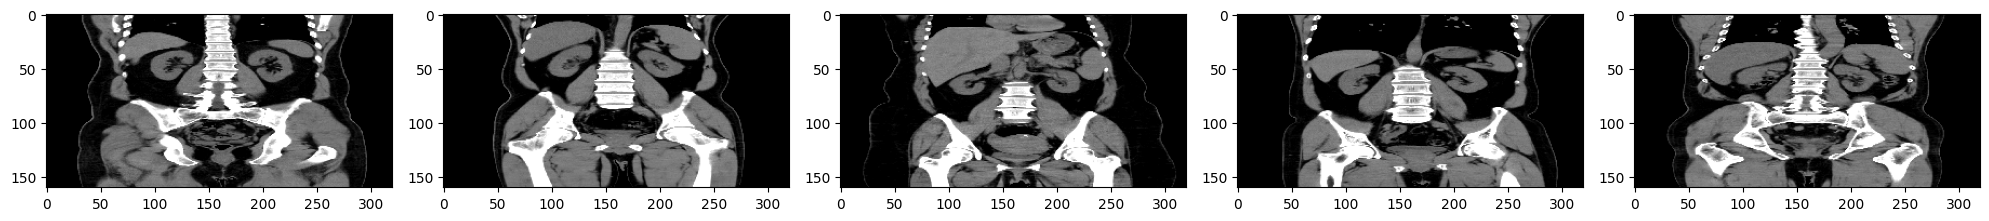

In [13]:
plotImages(sample_training_images[:5])  # Plot images 0-4

Define the Model

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(160, 320, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 318, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 159, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 157, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 78, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 76, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 38, 128)      0

In [43]:
EPOCHS = 100
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(1162 / float(batch_size))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(291  / float(batch_size)))
)

Epoch 1/100
10/10 [==============================] - 52s 5s/step - loss: 0.8472 - accuracy: 0.5198 - val_loss: 0.6941 - val_accuracy: 0.4364
Epoch 2/100
10/10 [==============================] - 50s 5s/step - loss: 0.6839 - accuracy: 0.5491 - val_loss: 0.6770 - val_accuracy: 0.5704
Epoch 3/100
10/10 [==============================] - 48s 5s/step - loss: 0.6721 - accuracy: 0.5706 - val_loss: 0.6629 - val_accuracy: 0.6564
Epoch 4/100
10/10 [==============================] - 55s 6s/step - loss: 0.6463 - accuracy: 0.6360 - val_loss: 0.6666 - val_accuracy: 0.6529
Epoch 5/100
10/10 [==============================] - 52s 5s/step - loss: 0.6139 - accuracy: 0.6704 - val_loss: 0.6319 - val_accuracy: 0.6254
Epoch 6/100
10/10 [==============================] - 51s 5s/step - loss: 0.5522 - accuracy: 0.7203 - val_loss: 0.6121 - val_accuracy: 0.6495
Epoch 7/100
10/10 [==============================] - 52s 6s/step - loss: 0.5015 - accuracy: 0.7565 - val_loss: 0.5907 - val_accuracy: 0.6907
Epoch 8/100
1